In [136]:
# Data update functionality
import os

from fabric import ThreadingGroup,Connection
from fabric.transfer import Transfer

# global configuration parameters
hosts = ["52.13.145.44", "52.89.179.9", "54.191.161.231", "54.218.172.167", "54.218.29.151", "34.222.0.168","18.237.96.142","54.68.198.213"]
key_file_loc = "~/.ssh/beam_competitions_key.pem"
dest_root = "/Users/sfeygi/current_code/others/prize_starter_kit/search-output/fixed/"

def connect_parallel(hosts,key_file_loc):
    return ThreadingGroup(*hosts,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def connect_single(host, key_file_loc):
    return Connection(host,user='ubuntu',connect_kwargs={"key_filename":[key_file_loc]})

def run(cmd, connection):
    return connection.run(cmd)

def run_n(cmd, connections):
    return [run(cmd,connection) for connection in connections]

def rsync_results(hostname, host_ip, key_file_loc, dest_root):
    return os.system(
        'rsync -avz -e "ssh -i {key_file_loc}" ubuntu@{host_ip}:/home/ubuntu//Uber-Prize-Starter-Kit/search-output-Exploration_1-fixed_inputs/ {dest_root}{hostname} --exclude="*/ITERS/" --exclude="*/output*" --exclude="*/competition/viz/" --exclude="*/summaryStats/"'.format(
            dest_root=dest_root,key_file_loc=key_file_loc, hostname=hostname, host_ip=host_ip))

# global other
host_names = ["host{}".format(str(i + 1)) for i in range(len(hosts))]
connection = connect_parallel(hosts,key_file_loc)

In [2]:
# try:
#     run('cd /home/ubuntu/Uber-Prize-Starter-Kit/utilities &&  \
#         git pull origin vgv/#55-adapt_ramdom_search', connection)
# except UnexpectedExit:
#     print("Already pulled in latest!")
# Ensure that docker image on server is latest (somewhat orthogonal to this notebook, but leaving here for now)
run('docker pull beammodel/beam-competition:0.0.1-SNAPSHOT',connection)


KeyboardInterrupt: 

In [140]:
# Pull latest results from server
[rsync_results(hostname, host_ip, key_file_loc,dest_root) for hostname, host_ip in zip(host_names, hosts)]

[0, 0, 0, 0, 0, 0, 0, 0]

In [9]:
import pandas as pd
import seaborn as sns
# import dask.dataframe as dd
from collections import defaultdict
import re
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [10]:
%matplotlib inline

In [11]:
# Parsing utilities
def split_range(range_repr):
    """
    Split's out a mathematial range representation into its component bounds.
    
    Exclusive ('(',')') bounds will have the left and/or right bounds properly
    augmented with +1 and -1, respectively. Inclusive bounds ('[',']') will remain
    as written.
    
    Parameters
    ----------
    range_repr : str
        A formatted representation of the range with exclusive and inclusive
        bounds represented as '(',')' and/or '[',']', respectively, for example,
        the range "(300:500]" represents all numbers between 300 (exclusive) and 500
        (inclusive).
    
    Returns
    -------
    str
        The input range representation as pair of integers with the ':' remaining to permit
        easy splitting with the series `str.split` function when the `expand` argument is `True`.
    
    Examples
    --------
    >>> split_range("(47000:202000]")
    '47001:202000'
    >>> split_range("(47000:202000]")
    '155000:176000'
    
    """
    if isinstance(range_repr,float):
        return "0:120"
    l,r = range_repr.strip("(),[]").split(":")
    l = int(l) + 1 if range_repr[0] is '(' else int(l) + 0
    r = int(r) - 1 if range_repr[-1] is ')' else int(r) + 0
    return "{}:{}".format(l,r)

# input_db = pd.concat(all_input_dfs).set_index("output_key")
def concat_and_set_index(df,name):
    return pd.concat(df[name]).set_index("output_key")
def expand_range_column(in_df,field):
    in_series = in_df.loc[:,field]
    in_df = in_series.apply(split_range).str.split(":",expand=True)
    in_df.columns = ["{}_low".format(field),"{}_high".format(field)]
#     in_df
    return in_df

def split_input_range(input_df,input_fields):
    tmp_res = []
    for input_field in input_fields:
        split_input_field=expand_range_column(input_df,input_field)
        input_df.drop(input_field,axis=1,inplace=True)
        tmp_res.append(split_input_field)
    input_type_df = pd.concat(tmp_res,axis=1)
    return pd.concat([input_df,input_type_df],axis=1)

def merge_input_type_df_with_score(input_df,scores_df,score_type):
    sub_scores = scores_df.loc[score_type]
    score_df = pd.merge(sub_scores,input_df,how="outer",right_index=True,left_on="output_key").set_index("output_key")
    return score_df.dropna(axis=0)

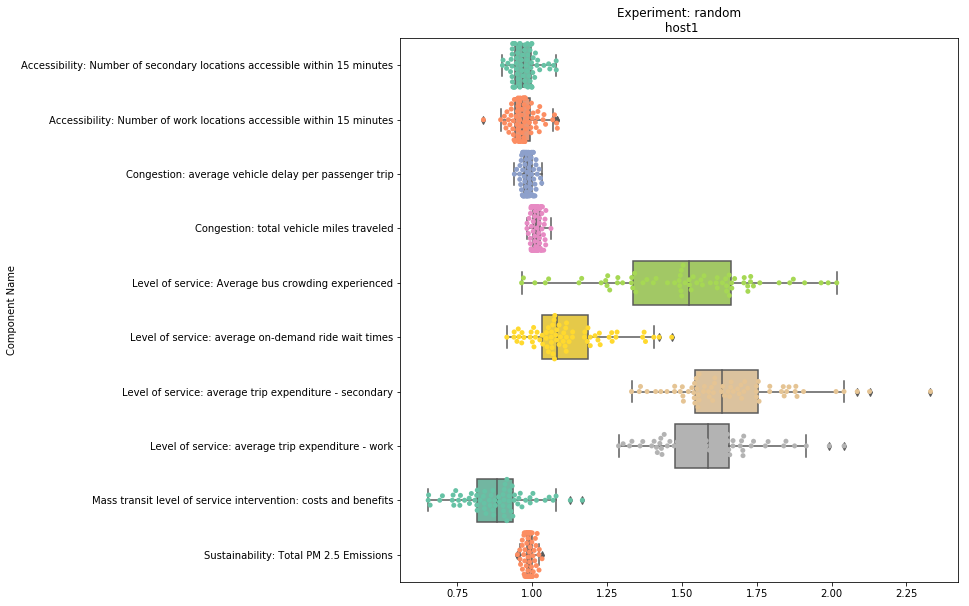

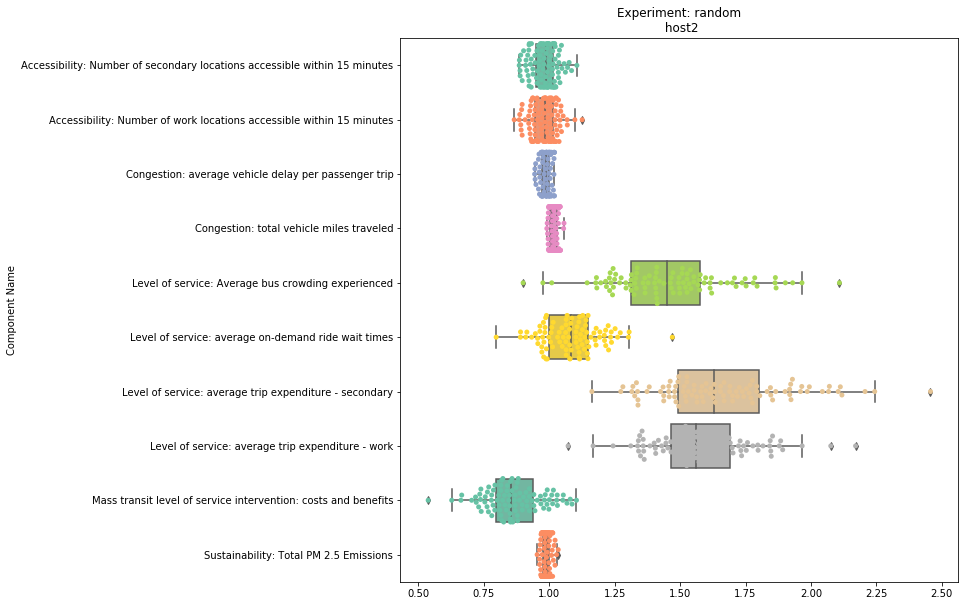

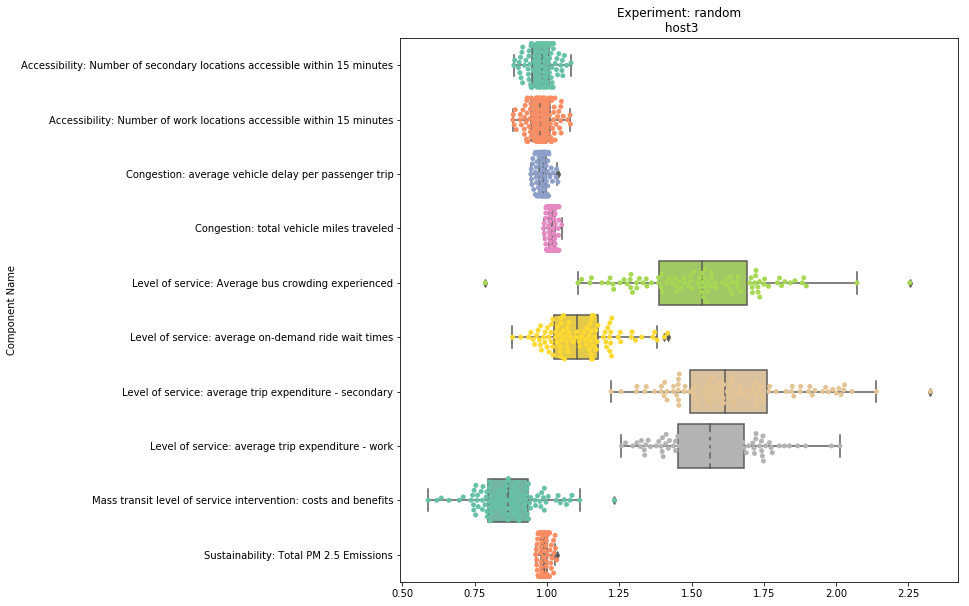

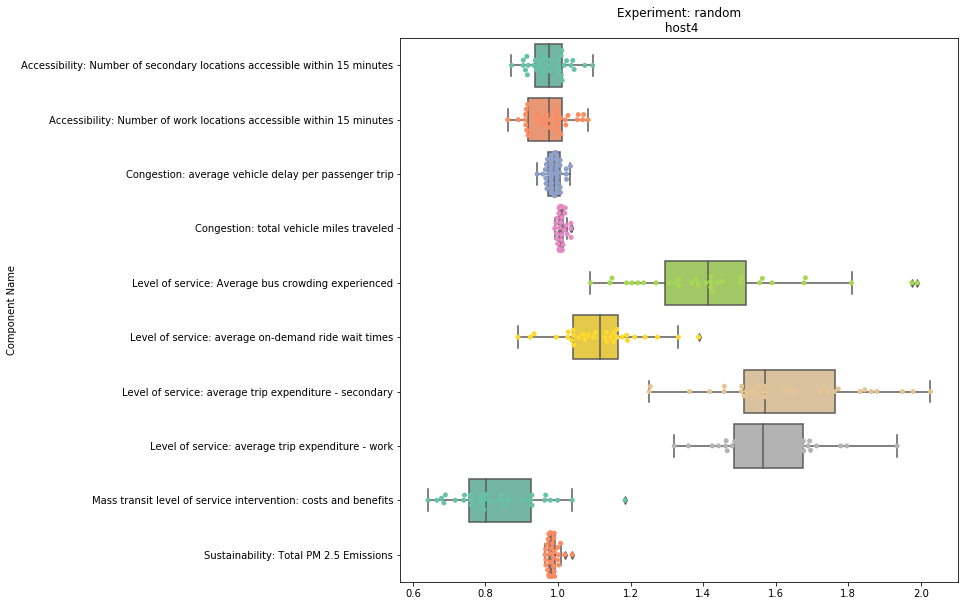

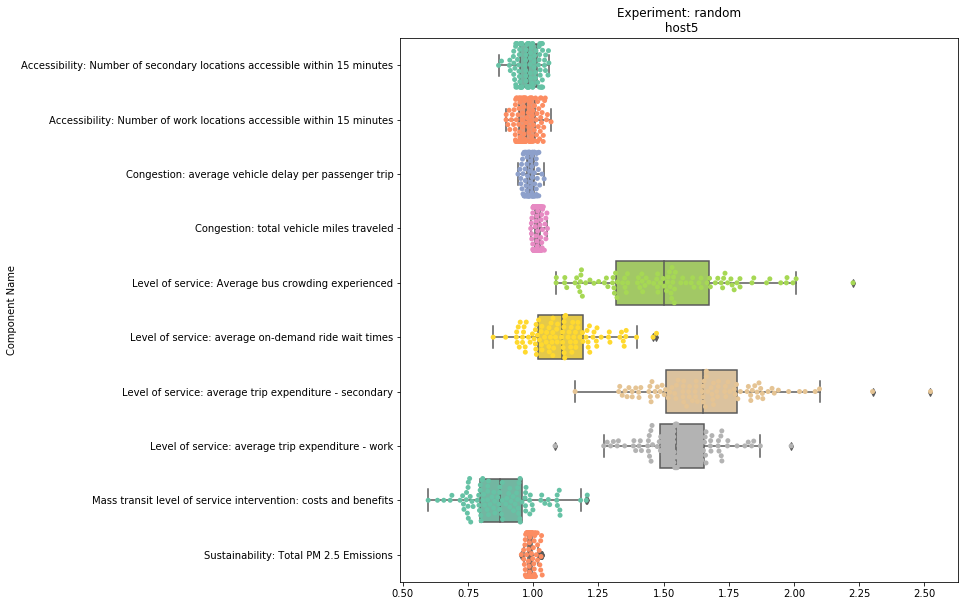

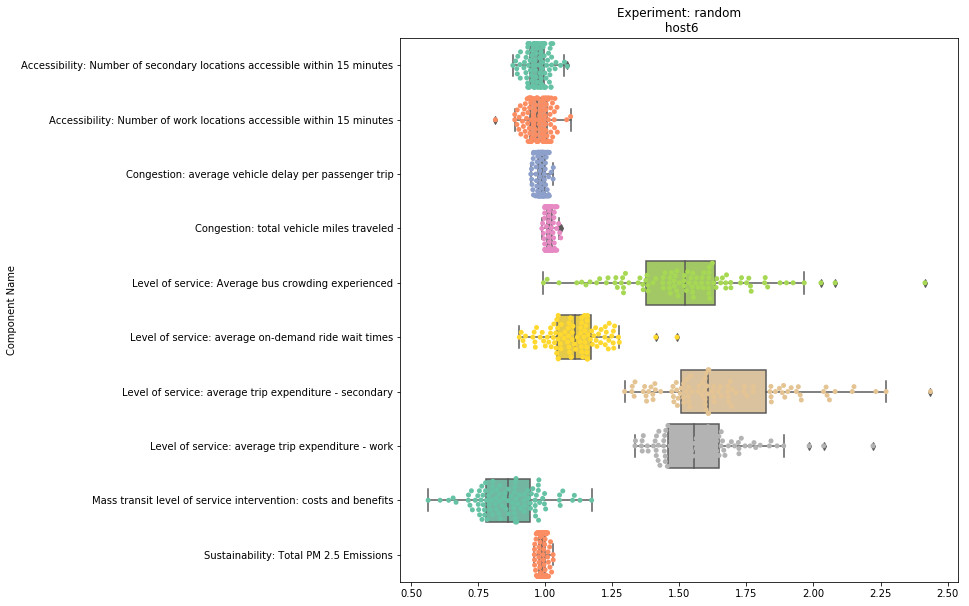

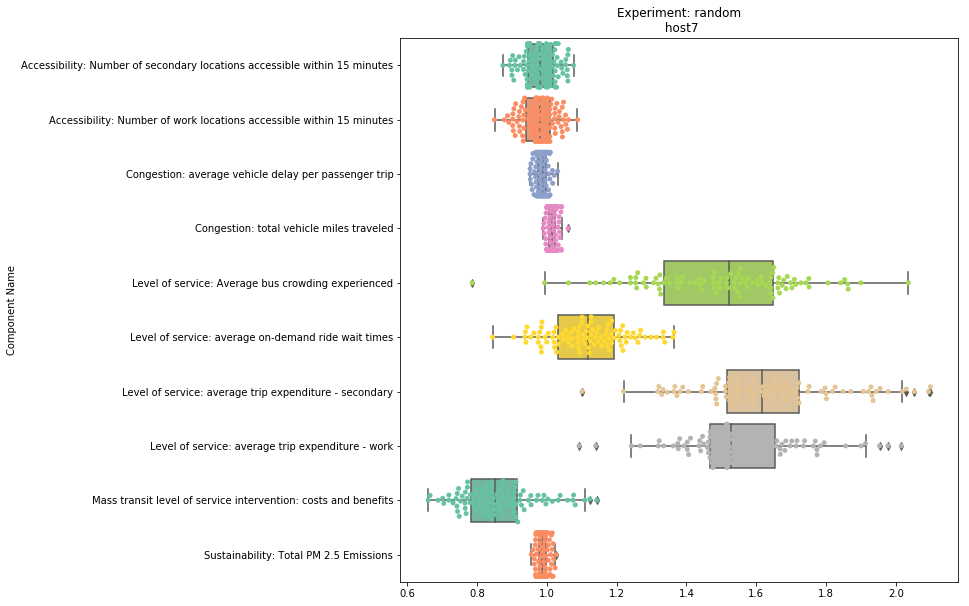

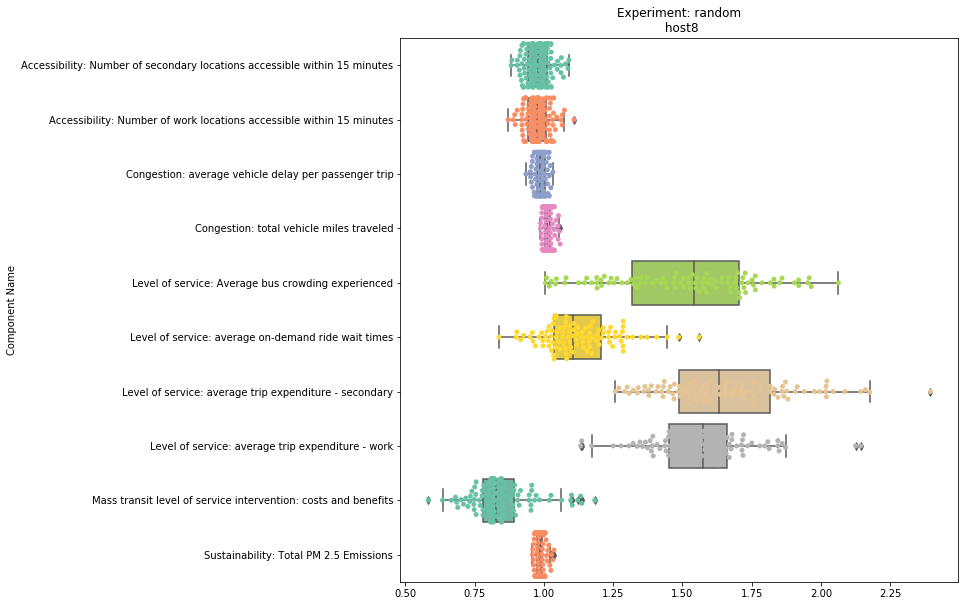

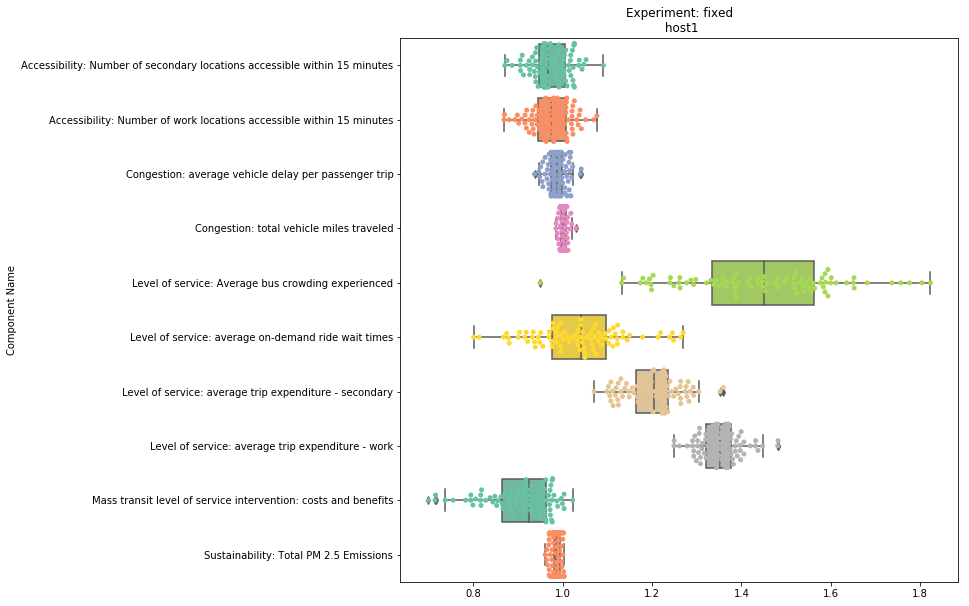

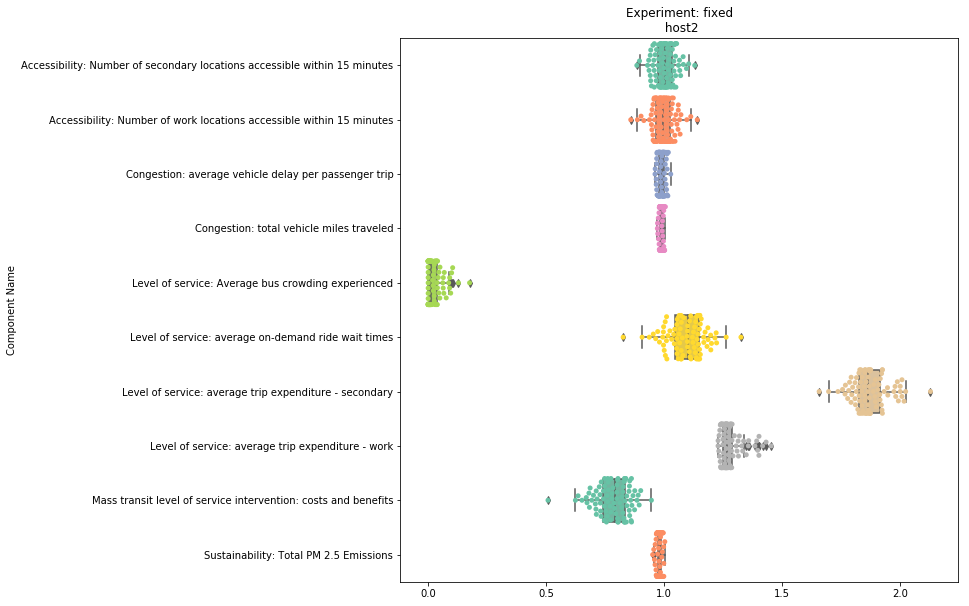

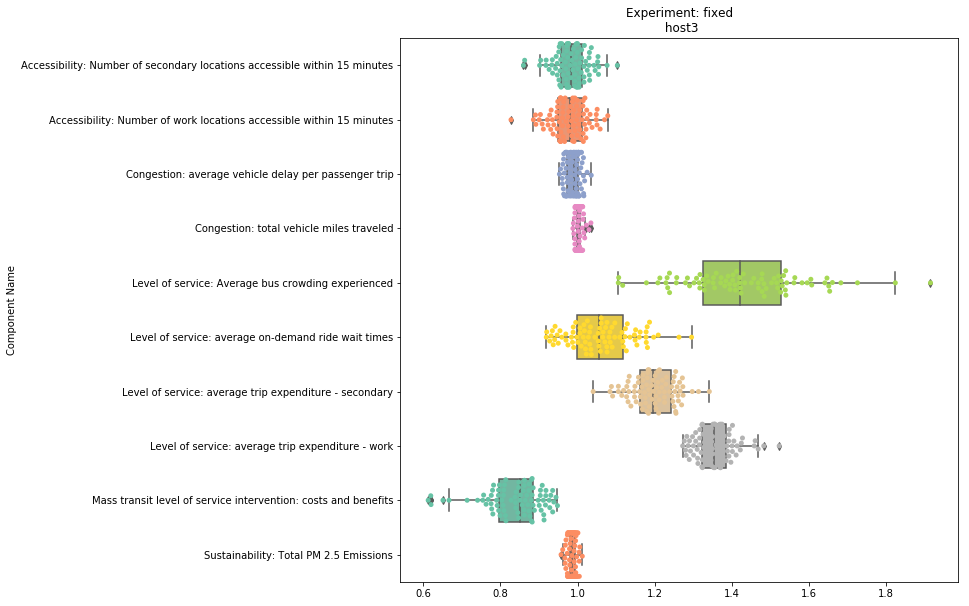

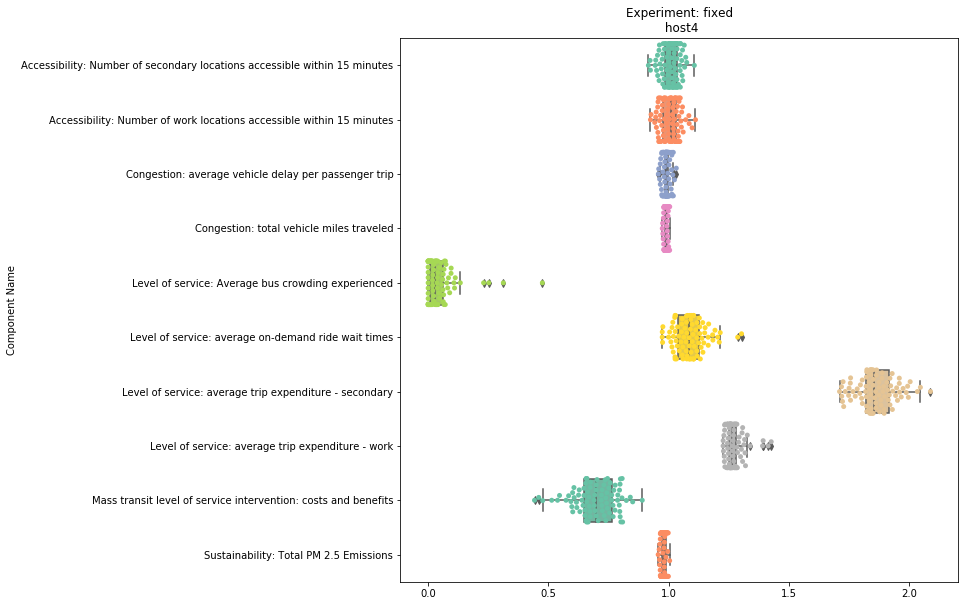

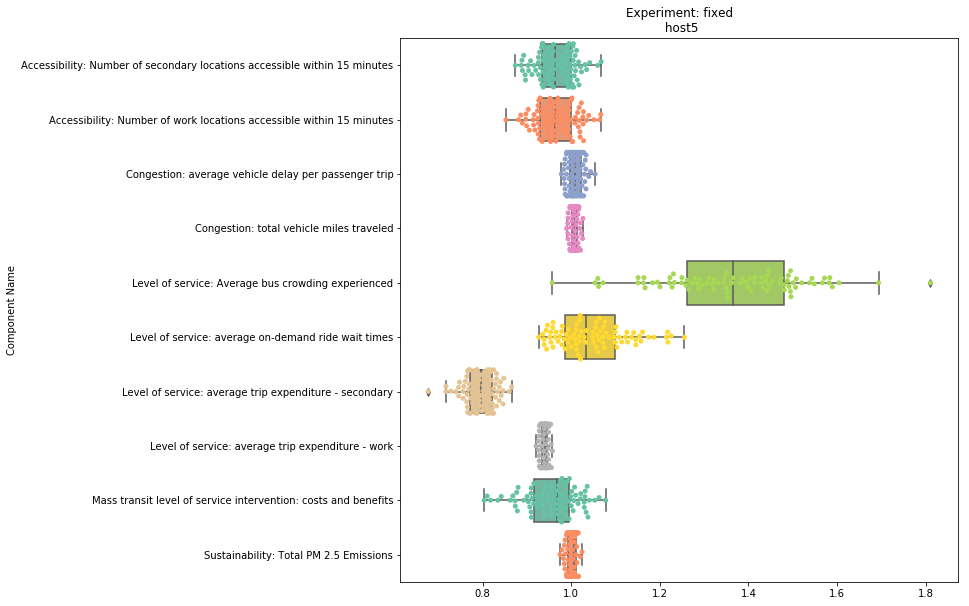

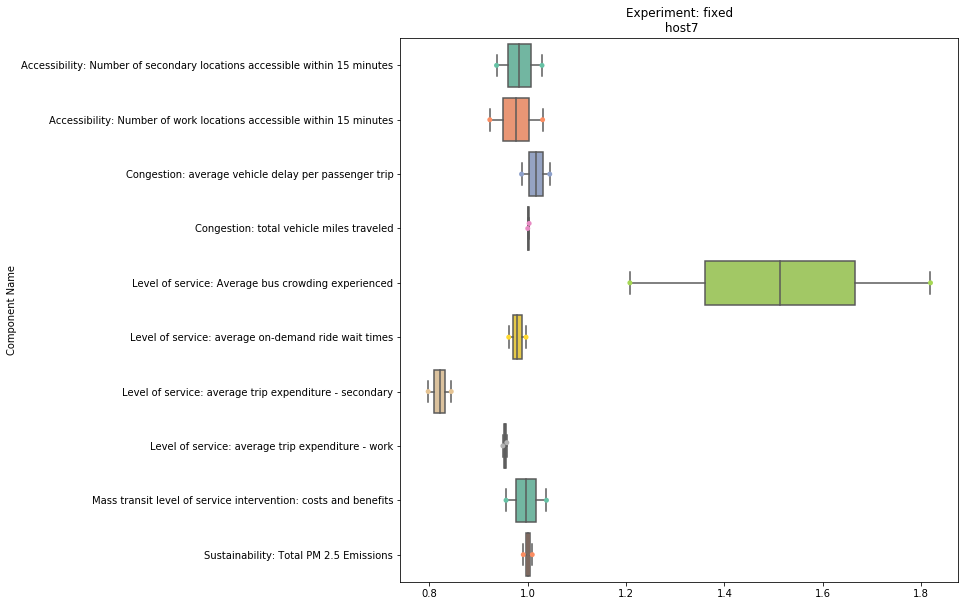

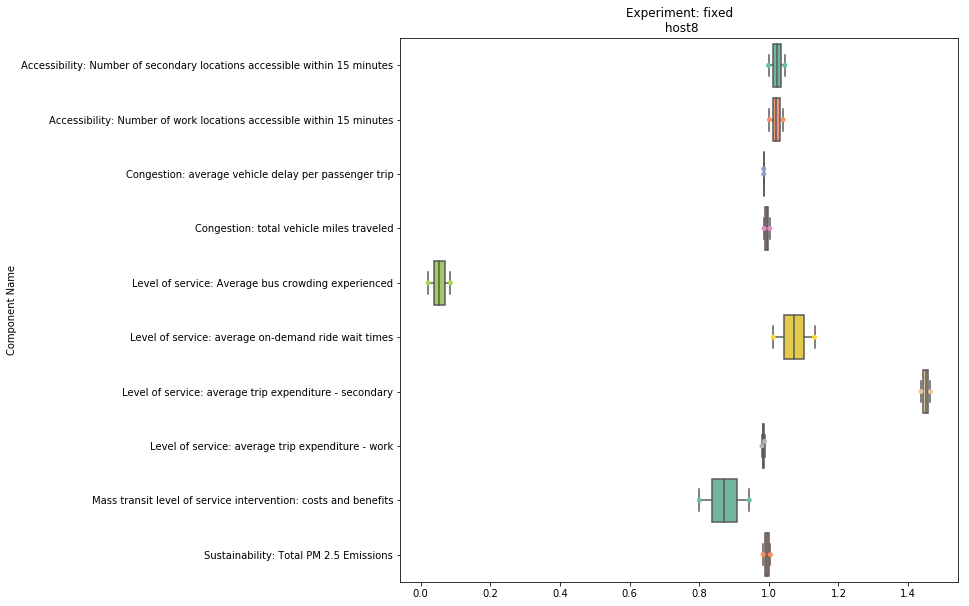

In [141]:
# collect, parse, and concatenate scores as well as plot by condition
import glob
experiment_types = ['random','fixed']
wide_score_dfs = []
for experiment_type in experiment_types:

    scores_dfs={}
    for host in host_names:
        try:
            common="../search-output/{}/{}/".format(experiment_type,host)
            output_dirs = glob.glob(common+"output*/sioux_faux/sioux_faux-15k*/competition/")


            sub_score_dfs = []
            all_input_dfs = defaultdict(list)
            SUBMISSION_INPUTS_DIR_NAME = "submission-inputs/"
            SUB_SCORE_NAME = "submissionScores.csv"
            input_names = ("FrequencyAdjustment","ModeIncentives","PtFares","VehicleFleetMix")

            for output_dir in output_dirs:
                # Load sub_score_dfs
                sub_score_file = output_dir + SUB_SCORE_NAME
                if not Path(sub_score_file).is_file():
                    continue
                score_df = pd.read_csv(sub_score_file,index_col="Component Name")
                output_key = re.findall("^.*output[_|-](.*?)(?:/sioux.*)$",output_dir)[0]
                if "RS" not in output_key:  # filter out old runs for now
                    continue
                score_df.loc[:,"output_key"] = output_key
                sub_score_dfs.append(score_df[["Raw Score","output_key"]])

                for input_name in input_names:
                    input_file = output_dir + SUBMISSION_INPUTS_DIR_NAME +"/"+ input_name+".csv"
                    if input_name == 'ModeIncentives':
                        input_df = pd.read_csv(input_file,dtype={'age':str})
                    else:
                        input_df = pd.read_csv(input_file)
                    if input_df.shape[0] == 0:
                        continue
                    input_df.loc[:,"output_key"] = output_key
                    input_df.index.name = 'obs_num'
                    all_input_dfs[input_name].append(input_df)


            freq_df = concat_and_set_index(all_input_dfs,"FrequencyAdjustment").drop('exact_times',axis=1)
            mode_df = concat_and_set_index(all_input_dfs,"ModeIncentives")
            ptfare_df = concat_and_set_index(all_input_dfs,"PtFares")
            vfm_df = concat_and_set_index(all_input_dfs,"VehicleFleetMix").drop("agencyId",axis=1)

            trip_id_factors = pd.factorize(freq_df.loc[:,"trip_id"])
            freq_df.loc[:,"trip_id"]=trip_id_factors[0]

            mode_factors = pd.factorize(mode_df.loc[:,"mode"])
            mode_df.loc[:,"mode"]=mode_factors[0]

            a,b = pd.factorize(list(set(ptfare_df.loc[:, "routeId"].values).union(set(ptfare_df.loc[:,"routeId"]))))
            mapping = dict(zip(b,a))
            ptfare_df.loc[:,"routeId"]=ptfare_df.loc[:,"routeId"].apply(lambda x: mapping[x])
            vfm_df.loc[:, "routeId"] = vfm_df.loc[:, "routeId"].apply(lambda x: mapping[x])

            vehicle_type_factors = pd.factorize(vfm_df.loc[:,"vehicleTypeId"])
            vfm_df.loc[:,"vehicleTypeId"] = vehicle_type_factors[0]

            input_type = "ModeIncentives"
            input_fields = ["income","age"]
            mode_df = split_input_range(mode_df.copy(),input_fields)

            input_type = "PtFares"
            input_fields = ["age"]
            ptfare_df = split_input_range(ptfare_df.copy(),input_fields)

            scores_df = pd.concat(sub_score_dfs)

            score_type = "Submission Score"
            freq_subscore_df = merge_input_type_df_with_score(freq_df,scores_df,score_type)
            mode_subscore_df = merge_input_type_df_with_score(mode_df,scores_df,score_type)
            ptfare_subscore_df = merge_input_type_df_with_score(ptfare_df,scores_df,score_type)
            vfm_subscore_df = merge_input_type_df_with_score(vfm_df,scores_df,score_type)

            freq_subscore_df=freq_subscore_df[freq_subscore_df["Raw Score"]>0]
            scores_df_wide = scores_df.reset_index().pivot(index='output_key',columns='Component Name',values='Raw Score')
            scores_dfs[host] = scores_df_wide
            fig = plt.figure(figsize=(10,10))
            sns.boxplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2')
            sns.swarmplot(data=scores_df_wide.drop("Submission Score",axis=1),orient='h',palette='Set2',color=".25")
            axis = fig.axes[0]
        #     axis.set_xlim(-0.25,5.0)
            plt.title("Experiment: {}\n {}".format(experiment_type,host))
            plt.show()
            fig.savefig("img/{}/{}.png".format(experiment_type, host),format="png",dpi=150)
        except ValueError:
            pass
    for k,df in scores_dfs.items():
        df['host'] = k
    wide_scores = pd.concat(list(scores_dfs.values()),axis=0)
    wide_scores = wide_scores.drop(['Submission Score','host'],axis=1).astype('float')
#     wide_scores['Accessibility: Number of secondary locations accessible within 15 minutes']=np.power(wide_scores['Accessibility: Number of secondary locations accessible within 15 minutes'],-1)
#     wide_scores['Accessibility: Number of work locations accessible within 15 minutes']=np.power(wide_scores['Accessibility: Number of work locations accessible within 15 minutes'],-1)
    
    wide_score_dfs.append(wide_scores)
wide_scores = pd.concat(wide_score_dfs,axis=0)

In [142]:
wide_scores.describe()

Component Name,Accessibility: Number of secondary locations accessible within 15 minutes,Accessibility: Number of work locations accessible within 15 minutes,Congestion: average vehicle delay per passenger trip,Congestion: total vehicle miles traveled,Level of service: Average bus crowding experienced,Level of service: average on-demand ride wait times,Level of service: average trip expenditure - secondary,Level of service: average trip expenditure - work,Mass transit level of service intervention: costs and benefits,Sustainability: Total PM 2.5 Emissions
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,0.982018,0.979415,0.989437,1.008599,1.247371,1.094181,1.551377,1.441591,0.853655,0.988189
std,0.044746,0.046367,0.018809,0.015922,0.565076,0.108294,0.340830,0.228410,0.116029,0.014859
min,0.859729,0.814492,0.935384,0.971398,0.000000,0.797168,0.676954,0.920490,0.442046,0.951445
25%,0.950011,0.947914,0.976305,0.997667,1.208480,1.018775,1.326733,1.305125,0.777765,0.977796
50%,0.983123,0.978666,0.989304,1.006441,1.419740,1.083257,1.593849,1.441462,0.850965,0.986753
75%,1.013382,1.012107,1.001972,1.018528,1.581907,1.154226,1.825494,1.597692,0.932671,0.996673
max,1.129784,1.140521,1.053776,1.063506,2.415618,1.559704,2.523275,2.221681,1.232881,1.039423


In [36]:

# grouped = pd.concat(list(scores_dfs.values()))
# melted=pd.melt(grouped.drop("Submission Score",axis=1),id_vars='host')
# fig = plt.figure(figsize=(50,50))

# sns.boxplot(y='Component Name',x='value',hue='host',data=melted,orient='h',palette='Set2')
# fig.savefig('img/{}/grouped.png'.format(experiment_type),dpi=300)

In [18]:
from sklearn.preprocessing import *

In [38]:
wide_scores = wide_scores.drop(['Submission Score','host'],axis=1).astype('float')

In [49]:
wide_scores['Accessibility: Number of secondary locations accessible within 15 minutes']=np.power(wide_scores['Accessibility: Number of secondary locations accessible within 15 minutes'],-1)
wide_scores['Accessibility: Number of work locations accessible within 15 minutes']=np.power(wide_scores['Accessibility: Number of work locations accessible within 15 minutes'],-1)
wide_scores = np.power(wide_scores,-1)


In [116]:
bus_crowding=wide_scores['Level of service: Average bus crowding experienced']


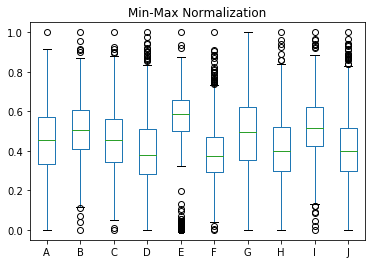

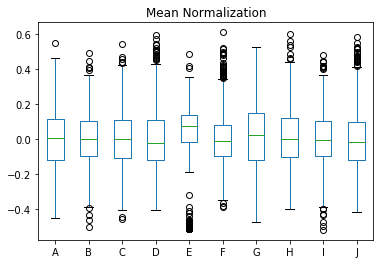

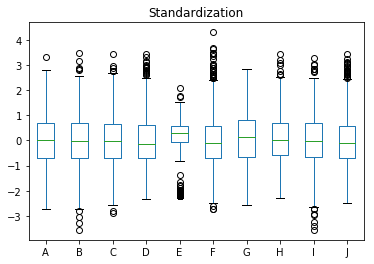

In [143]:
columns = ['A','B','C','D','E','F','G','H','I','J']
mins = np.nanmin(wide_scores.values,axis=0)
maxs = np.nanmax(wide_scores.values,axis=0)
denom = maxs-mins
means = np.nanmean(wide_scores.values,axis=0)
variances = wide_scores.values.var(axis=0)
stds = wide_scores.values.std(axis=0)

# min-max normalization
pd.DataFrame((wide_scores.values-mins)/denom,columns=columns).plot(kind='box',title='Min-Max Normalization')
plt.savefig('img/min_max_norm.png',format='png',dpi=150)
plt.show()

# mean normalization
pd.DataFrame((wide_scores.values-means)/denom,columns=columns).plot(kind='box',title='Mean Normalization')
plt.savefig('img/mean_norm.png',format='png',dpi=150)
plt.show()

# standardization
pd.DataFrame(((wide_scores.values-means)/stds),columns=columns).plot(kind='box',title='Standardization')
plt.savefig('img/standardization.png',format='png',dpi=150)
plt.show()

In [70]:
dict(zip(columns,wide_scores.columns.values))

{'A': 'Accessibility: Number of secondary locations accessible within 15 minutes',
 'B': 'Accessibility: Number of work locations accessible within 15 minutes',
 'C': 'Congestion: average vehicle delay per passenger trip',
 'D': 'Congestion: total vehicle miles traveled',
 'E': 'Level of service: Average bus crowding experienced',
 'F': 'Level of service: average on-demand ride wait times',
 'G': 'Level of service: average trip expenditure - secondary',
 'H': 'Level of service: average trip expenditure - work',
 'I': 'Mass transit level of service intervention: costs and benefits',
 'J': 'Sustainability: Total PM 2.5 Emissions'}

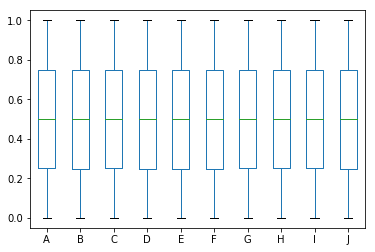

In [147]:

transformer = QuantileTransformer(output_distribution='uniform')
transformed = transformer.fit_transform(wide_scores.values)
pd.DataFrame(transformed,columns=columns).plot(kind='box')

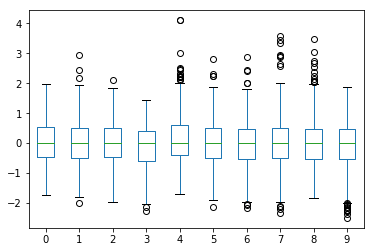

In [60]:
pd.DataFrame(robust_scale(wide_scores.values)).plot(kind='box')

In [13]:
from pandas.plotting import parallel_coordinates

In [14]:
data=scores_dfs['host5']['Level of service: average trip expenditure - secondary']
data[data>data.quantile(0.93)]

output_key
C5_RS11-e0rl6j9m    0.865270
C5_RS26-drf__twk    0.847741
C5_RS33-jewputcp    0.845844
C5_RS43-z9li71dw    0.841774
C5_RS56-tzyxgn7w    0.846002
Name: Level of service: average trip expenditure - secondary, dtype: float64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

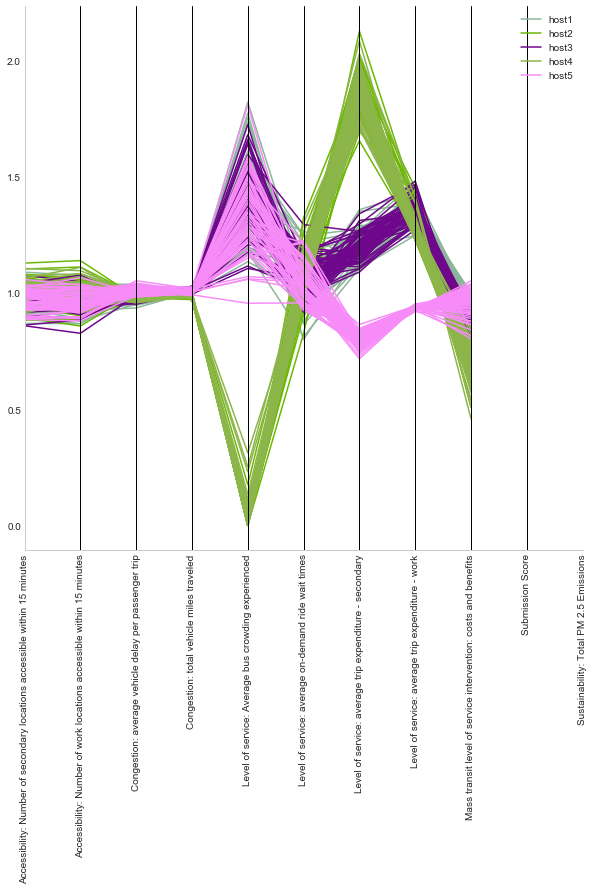

In [18]:
sns.set_palette('Set2')
sns.set_style('whitegrid')
# sns.set_context('notebook')
fig = plt.figure(figsize=(10,10))
axes=parallel_coordinates(wide_scores,'host')
sns.despine()
plt.xticks(rotation=90)



In [77]:
# radar chart
# wide_scores = wide_scores.drop('Submission Score',axis=1)
labels = wide_scores.columns.values[:-1]
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
labels

array(['Accessibility: Number of secondary locations accessible within 15 minutes',
       'Accessibility: Number of work locations accessible within 15 minutes',
       'Congestion: average vehicle delay per passenger trip',
       'Congestion: total vehicle miles traveled',
       'Level of service: Average bus crowding experienced',
       'Level of service: average on-demand ride wait times',
       'Level of service: average trip expenditure - secondary',
       'Level of service: average trip expenditure - work',
       'Mass transit level of service intervention: costs and benefits',
       'Submission Score', 'Sustainability: Total PM 2.5 Emissions'],
      dtype=object)

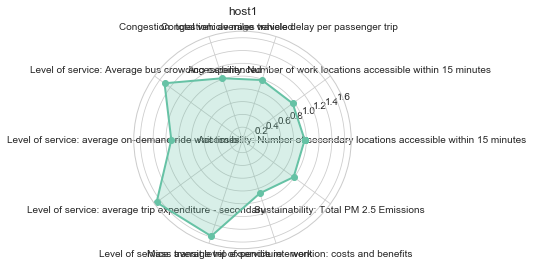

In [51]:
stats1=np.concatenate((stats1,[stats1[0]]))
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats1, 'o-', linewidth=2)
ax.fill(angles, stats1, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title(stats.index[0])
ax.grid(True)

In [75]:
sub_score_df=sub_score_df.set_index('output_key')
sub_score_df.index.name = 'output_key'

NameError: name 'sub_score_df' is not defined

In [76]:
freq_df=pd.merge(sub_scores["a"],input_db["VehicleFleetMix"],how="outer",right_index=True,left_on=[("output_key")])

NameError: name 'sub_scores' is not defined

In [148]:
df = wide_scores.drop(['host','Submission Score'],axis=1)

/Users/sfeygi/anaconda3/lib/python3.6/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


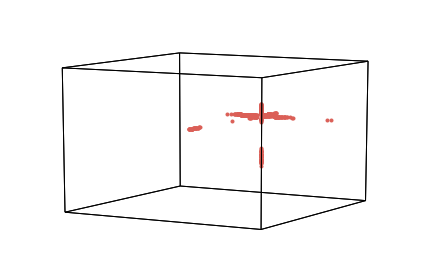

In [150]:
geo = hyp.plot(df,'.',normalize='across',reduce='MiniBatchDictionaryLearning',explore=True)

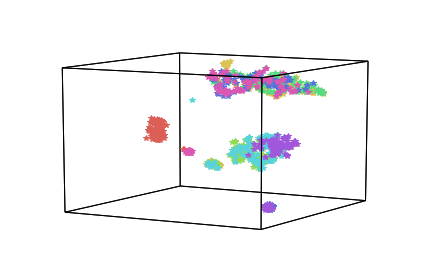

In [154]:
hyp.plot([df.drop(['host','Submission Score'],axis=1).values for df in scores_dfs.values()],'*',reduce='TSNE')

In [306]:
test_df["Weighted Score"].describe()

count    1040.000000
mean     1179.355861
std      1450.967800
min         0.000000
25%       271.386123
50%       686.453723
75%      1530.935567
max      7697.940789
Name: Weighted Score, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d9bfef0>,
      dtype=object)

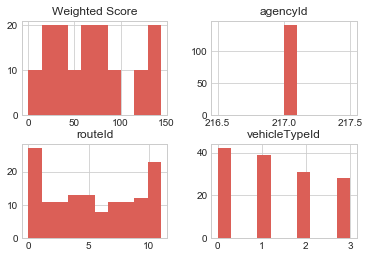

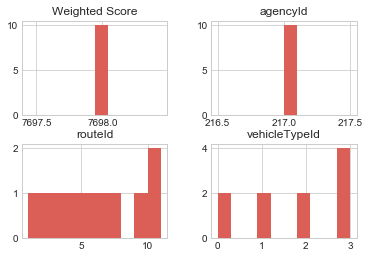

In [310]:
test_df[test_df["Weighted Score"]<150].hist()
test_df[test_df["Weighted Score"]>7030].hist()

-25.328436022934504

In [308]:
test_df[test_df["Weighted Score"]>1571]

,Weighted Score,agencyId,routeId,vehicleTypeId
60,2442.538930,217,10,3
61,2442.538930,217,6,2
62,2442.538930,217,0,1
63,2442.538930,217,9,2
64,2442.538930,217,3,2
65,2442.538930,217,5,1
66,2442.538930,217,11,3
67,2442.538930,217,1,3
68,2442.538930,217,4,1
69,2442.538930,217,2,0
